**Transferencia de estilo neuronal**

La transferencia de estilo neuronal es una técnica de optimización utilizada para tomar dos imágenes, una imagen de contenido y una imagen de referencia de estilo (como una obra de arte de un pintor famoso), y combinarlas para que la imagen de salida se vea como la imagen de contenido, pero "pintada". en el estilo de la imagen de referencia de estilo.
Esto se implementa mediante la optimización de la imagen de salida para que coincida con las estadísticas de contenido de la imagen de contenido y las estadísticas de estilo de la imagen de referencia de estilo. Estas estadísticas se extraen de las imágenes utilizando una **red convolucional**.

Importar y configurar módulos



In [49]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import IPython.display as display
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [50]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

Descarga Imagenes

In [51]:
content_path = '..\Transferencia_de_estilo\KALU.jpg'
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

*Visualiza la entrada*

Defina una función para cargar una imagen y limite su dimensión máxima a 512 píxeles.

In [52]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Cree una función simple para mostrar una imagen:

In [53]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

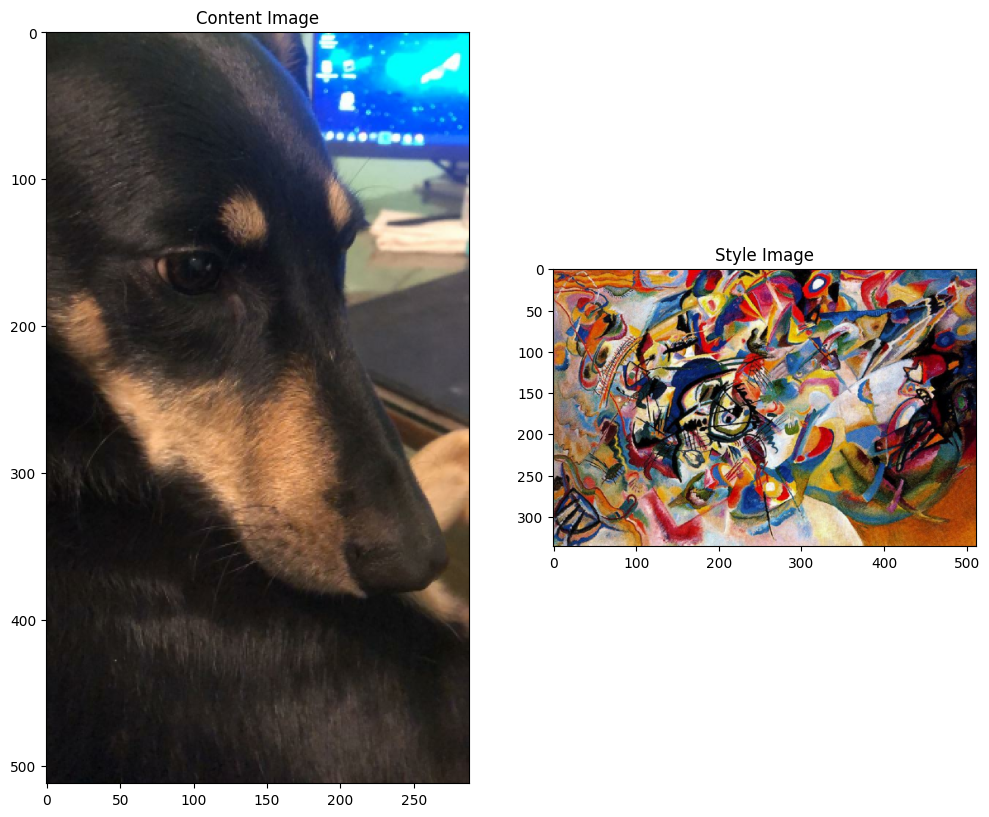

In [11]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

*Transferencia de estilo rápido usando TF-Hub*

transferencia de estilo original, que optimiza el contenido de la imagen a un estilo particular.


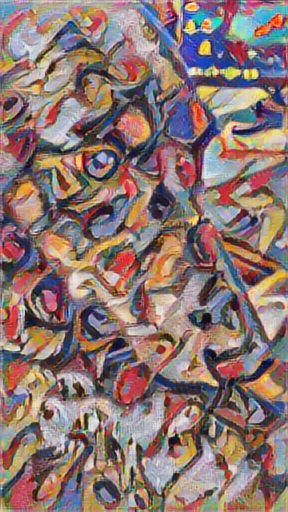

In [54]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

*Construye el modelo.*

En este caso, está utilizando la arquitectura de red VGG19, una red de clasificación de imágenes previamente entrenada. Estas capas intermedias son necesarias para definir la representación de contenido y estilo de las imágenes.

Cargue un VGG19 y pruébelo en nuestra imagen para asegurarse de que se usa correctamente:


In [55]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

Podemos ver de que Raza cree la red que es mi perro

In [56]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('kelpie', 0.31479713),
 ('Doberman', 0.27148056),
 ('miniature_pinscher', 0.25330508),
 ('toy_terrier', 0.09016406),
 ('Saluki', 0.030232415)]

Ahora cargo un VGG19 sin el cabezal de clasificación y enumero los nombres de las capas

In [57]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Elijo capas intermedias de la red para representar el estilo y el contenido de la imagen:

In [58]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Las redes en tf.keras.applications están diseñadas para que pueda extraer fácilmente los valores de la capa intermedia utilizando la API funcional de Keras.

Para definir un modelo utilizando la API funcional, especifique las entradas y salidas:


La siguiente función crea un modelo VGG19 que devuelve una lista de salidas de capa intermedia:

In [59]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [18]:
#CREAR EL MODELO
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8867
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.133
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2532
  mean:  59.179478



Calcular estilo

El contenido de una imagen está representado por los valores de los mapas de características intermedias.
Resulta que el estilo de una imagen se puede describir por los medios y las correlaciones entre los diferentes mapas de características.

In [60]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

*Extraer estilo y contenido*

Un modelo que devuelva los tensores de estilo y contenido.

In [61]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

Cuando se llama a una imagen, este modelo devuelve la matriz de gram(estilo) de las style_layers de estilo y el contenido de las content_layers de contenido:

In [62]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055957683
    max:  30466.125
    mean:  528.5768

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  68708.586
    mean:  10870.259

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  374371.0
    mean:  10270.476

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4176343.0
    mean:  170663.72

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  50410.082
    mean:  1039.5511

Contents:
   block5_conv2
    shape:  (1, 32, 18, 512)
    min:  0.0
    max:  1291.9192
    mean:  12.203891


*Ejecutar descenso de gradiente*

Con este extractor de estilo y contenido, ahora puedO implementar el algoritmo de transferencia de estilo. Haga esto calculando el error cuadrático medio para la salida de su imagen en relación con cada objetivo, luego tome la suma ponderada de estas pérdidas.

Establezco sus valores objetivo de estilo y contenido:

In [63]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Defina una tf.Variable para contener la imagen a optimizar.

In [64]:
image = tf.Variable(content_image)

Dado que esta es una imagen flotante, defina una función para mantener los valores de píxel entre 0 y 1:

In [65]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Crear un optimizador. El documento recomienda LBFGS, pero Adam también funciona bien:

In [66]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Para optimizar esto, use una combinación ponderada de las dos pérdidas para obtener la pérdida total:

In [67]:
style_weight=1e-2
content_weight=1e4

In [68]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [69]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Ahora ejecute algunos pasos para probar:

In [48]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

KeyError: ignored

Ya que está funcionando, realice una optimización más larga:

In [43]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

KeyError: ignored

Una desventaja de esta implementación básica es que produce muchos artefactos de alta frecuencia. Disminuimos estos utilizando un término de regularización explícito en los componentes de alta frecuencia de la imagen. En la transferencia de estilo, esto a menudo se denomina pérdida de variación total :

In [70]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

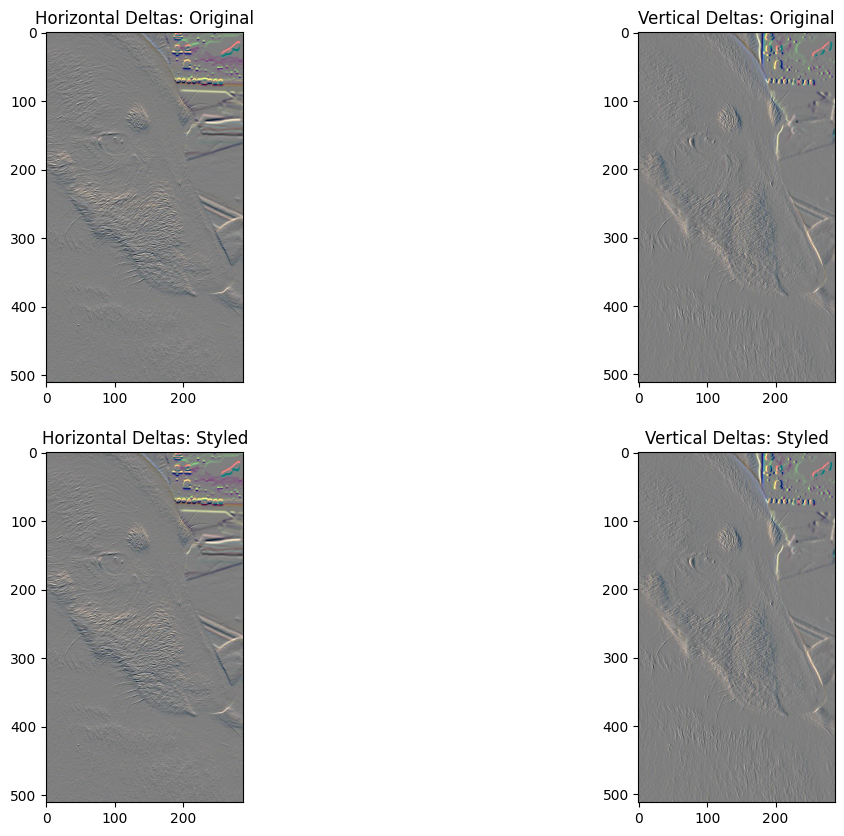

In [71]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

Esto muestra cómo han aumentado los componentes de alta frecuencia.

Además, este componente de alta frecuencia es básicamente un detector de bordes. Puede obtener un resultado similar del detector de bordes Sobel, por ejemplo:

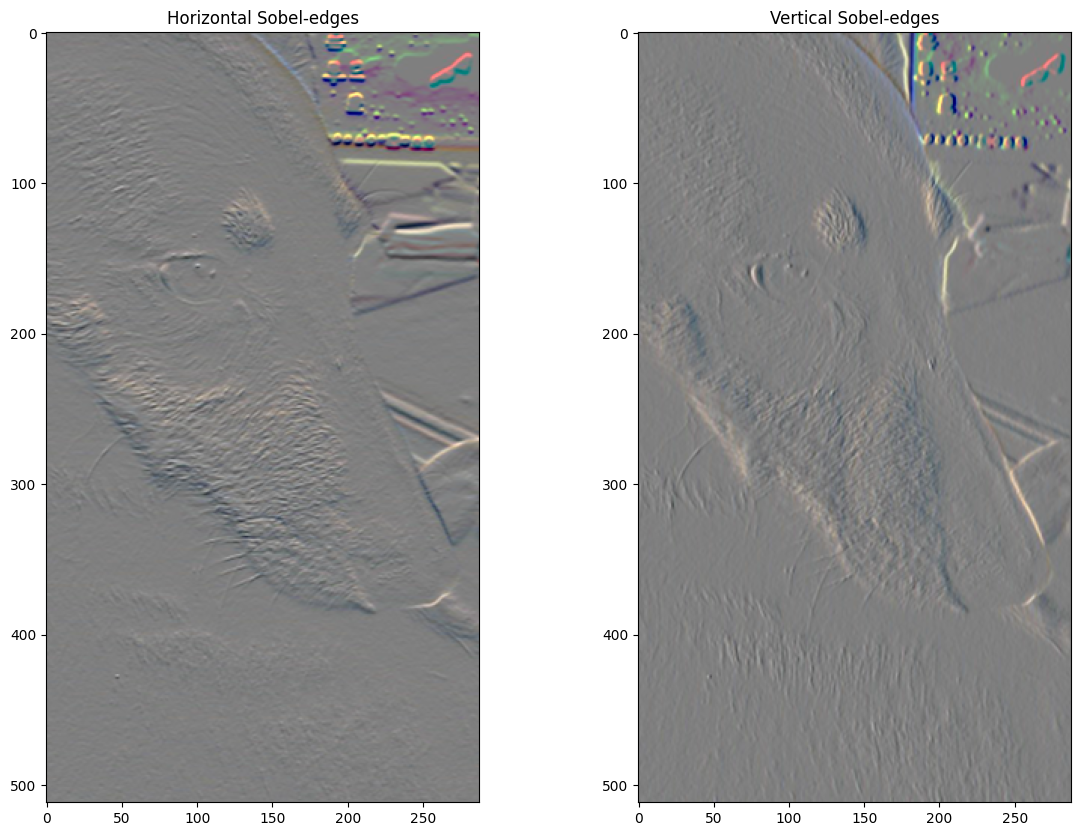

In [72]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

La pérdida de regularización asociada a esto es la suma de los cuadrados de los valores:



In [73]:
tf.image.total_variation(image).numpy()

array([14748.6455], dtype=float32)

#Vuelvo a ejecutar la optimización

Elijo un peso para total_variation_loss y lo incluyo en la función train_step :


In [74]:
total_variation_weight=30
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinicio la variable de optimización:



In [75]:
image = tf.Variable(content_image)

Y ejecuta la optimización:



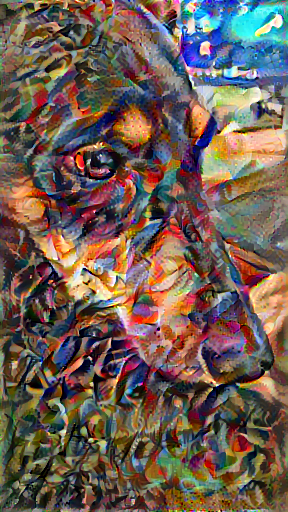

Train step: 1000
Total time: 5917.7


In [76]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Guardamos el Resultado.

In [77]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>